In [1]:
import obonet
import networkx as nx
import pandas as pd
import numpy as np
from math import log
from typing import Iterable, Tuple, Dict, List, Set
import matplotlib.pyplot as plt

In [ ]:
# 1) download or point to a local copy of BTO OBO/OWL
# BTO URL (example purl): http://purl.obolibrary.org/obo/bto.owl
bto_path = "bto.obo"  # download manually or via requests and save

# parse
graph = obonet.read_obo(bto_path)  # This builds a networkx.MultiDiGraph

# make an undirected simple graph for shortest-path distance (optional)
G_undir = nx.Graph()
for u, v, d in graph.edges(data=True):
    # treat all relationships as undirected edges — you can filter by d['type'] if needed
    G_undir.add_edge(u, v)




Graph has cycles: [['BTO:0006348', 'BTO:0000958', 'BTO:0006349', 'BTO:0002666'], ['BTO:0000535', 'BTO:0001275', 'BTO:0000958'], ['BTO:0000082', 'BTO:0001230', 'BTO:0001275', 'BTO:0000958'], ['BTO:0000082', 'BTO:0003096', 'BTO:0001234', 'BTO:0002053', 'BTO:0001230'], ['BTO:0000082', 'BTO:0000080', 'BTO:0001698', 'BTO:0003096'], ['BTO:0001129', 'BTO:0000080', 'BTO:0001698', 'BTO:0003096'], ['BTO:0000282', 'BTO:0001090', 'BTO:0005375', 'BTO:0005374', 'BTO:0000375', 'BTO:0005481', 'BTO:0001113', 'BTO:0001111', 'BTO:0000080', 'BTO:0001698', 'BTO:0003096', 'BTO:0001234', 'BTO:0002053', 'BTO:0001230', 'BTO:0001275', 'BTO:0000958', 'BTO:0006349', 'BTO:0002666', 'BTO:0006078', 'BTO:0001489'], ['BTO:0006516', 'BTO:0006517', 'BTO:0001090'], ['BTO:0001775', 'BTO:0002860', 'BTO:0001090'], ['BTO:0002637', 'BTO:0002926', 'BTO:0002927', 'BTO:0002925', 'BTO:0000419'], ['BTO:0001653', 'BTO:0004299', 'BTO:0003213', 'BTO:0002637', 'BTO:0000419'], ['BTO:0002022', 'BTO:0000353', 'BTO:0003213', 'BTO:0002637'

In [3]:
# Manual GTEX to BTO mapping.
gtex_to_bto = {
    "Adipose_Tissue" : "BTO:0001487", 
    "Adrenal_Gland" : "BTO:0000047", 
    "Bladder" : "BTO:0001418", 
    "Blood" : "BTO:0000089", 
    "Blood_Vessel" : "BTO:0001102",
    "Brain" : "BTO:0000142", 
    "Breast" : "BTO:0000149", 
    "Cervix_Uteri" : "BTO:0002249", 
    "Colon" : "BTO:0000269", 
    "Esophagus" : "BTO:0000959",
    "Fallopian_Tube" : "BTO:0000980", 
    "Heart" : "BTO:0000562", 
    "Kidney" : "BTO:0000671", 
    "Liver" : "BTO:0000759", 
    "Lung" : "BTO:0000763",
    "Muscle" : "BTO:0000887", 
    "Nerve" : "BTO:0000925", 
    "Ovary" : "BTO:0000975", 
    "Pancreas" : "BTO:0000988", 
    "Pituitary" : "BTO:0001073",
    "Prostate" : "BTO:0001129", 
    "Salivary_Gland" : "BTO:0001203", 
    "Skin" : "BTO:0001253", 
    "Small_Intestine" : "BTO:0000651", 
    "Spleen" : "BTO:0001281",
    "Stomach" : "BTO:0001307", 
    "Testis" : "BTO:0001363", 
    "Thyroid" : "BTO:0001379", 
    "Uterus" : "BTO:0001424", 
    "Vagina" : "BTO:0000243"
}
gtex_terms = list(gtex_to_bto.values())

In [18]:
def minimal_subtree(G: nx.Graph, O: Iterable) -> nx.Graph:
    """
    Return the minimal connected subtree H of the tree G that contains all nodes in O.
    G must be a tree (connected acyclic).
    """
    O = list(O)
    if len(O) == 0:
        return G.subgraph([]).copy()
    if len(O) == 1:
        return G.subgraph(O).copy()

    # Pick a reference node and union the shortest paths between all offspring
    ref = O[0]
    nodes_in_subtree: Set = set()
    for o in O:
        path = nx.shortest_path(G, ref, o)
        nodes_in_subtree.update(path)
    return G.subgraph(nodes_in_subtree).copy()


def find_root_in_subtree(G: nx.Graph, H: nx.Graph, original_root) -> object:
    """
    Return the node in H that is closest to original_root in G.
    """
    # Compute shortest path distances in G (tree, so simple)
    dist = nx.shortest_path_length(G, source=original_root)
    # Pick node in H with minimal distance
    return min(H.nodes(), key=lambda n: dist.get(n, float('inf')))


def contract_subpaths(H: nx.Graph, root_H, O: Iterable) -> Tuple[nx.Graph, Dict[Tuple, List]]:
    """
    Contract subpaths in H that contain only nodes NOT in O or the root_H.

    Returns:
      - C: contracted graph
      - path_map: mapping (u, v) -> list_of_nodes_in_H along the contracted path
    """
    Oset = set(O)
    deg = dict(H.degree())

    # Nodes that should always be kept
    kept = set(n for n in H.nodes if (n in Oset) or (deg.get(n, 0) != 2) or (n == root_H))

    C = nx.Graph()
    C.add_nodes_from(kept)

    path_map: Dict[Tuple, List] = {}
    visited_edges = set()

    def walk_path(start: object, neighbor: object):
        """Walk along degree-2 chain until reaching a kept node."""
        path = [start, neighbor]
        cur = neighbor
        prev = start
        while cur not in kept:
            nbrs = [x for x in H.neighbors(cur) if x != prev]
            if not nbrs:
                break
            nxt = nbrs[0]
            path.append(nxt)
            prev, cur = cur, nxt
        return cur, path

    for u in kept:
        for v in H.neighbors(u):
            ekey = tuple(sorted((u, v)))
            if ekey in visited_edges:
                continue
            endpoint, path_nodes = walk_path(u, v)
            for a, b in zip(path_nodes[:-1], path_nodes[1:]):
                visited_edges.add(tuple(sorted((a, b))))
            a, b = u, endpoint
            if a == b:
                continue
            key = tuple(sorted((a, b)))
            if key not in path_map:
                path_map[key] = path_nodes
                C.add_edge(a, b, length=len(path_nodes) - 1, path=path_nodes)

    return C, path_map


def minimal_contracted_subtree(G: nx.Graph, original_root, O: Iterable) -> Tuple[nx.Graph, nx.Graph, object, Dict[Tuple, List]]:
    """
    Given tree G, original root, and offspring O,
    returns (H, C, root_H, path_map):
      - H: minimal subtree containing O
      - root_H: node in H closest to original_root in G
      - C: contracted version of H preserving root_H and O
      - path_map: mapping from edges in C to node paths in H
    """
    H = minimal_subtree(G, O)
    root_H = find_root_in_subtree(G, H, original_root)
    C, path_map = contract_subpaths(H, root_H, O)
    return H, C, root_H, path_map

def hierarchy_pos(G, root, width=1., vert_gap=0.3):
    """
    Compute hierarchical layout for a tree rooted at `root`.
    Smaller vert_gap -> shorter edges.
    """
    T = nx.bfs_tree(G, root)
    sizes = {}

    def _subtree_sizes(node):
        children = list(T.neighbors(node))
        if not children:
            sizes[node] = 1
            return 1
        s = sum(_subtree_sizes(c) for c in children)
        sizes[node] = s
        return s

    _subtree_sizes(root)
    pos = {}

    def _assign(node, left, right, depth):
        x = (left + right) / 2
        y = -depth * vert_gap
        pos[node] = (x, y)
        children = list(T.neighbors(node))
        if not children:
            return
        span = right - left
        cur = left
        for c in children:
            frac = sizes[c] / sum(sizes[ch] for ch in children)
            nxt = cur + span * frac
            _assign(c, cur, nxt, depth + 1)
            cur = nxt

    _assign(root, 0, width, 0)
    return pos


def plot_contracted_subtree_labels_only_O(C: nx.Graph, root_H, O, bto_to_gtex: dict):
    """
    Plot contracted subtree C as a tree (root_H at top),
    showing labels only for nodes in O.
    Labels are rotated 90 degrees and shown below each node.
    """
    pos = hierarchy_pos(C, root_H, vert_gap=0.3)
    plt.figure(figsize=(10, 8))

    # Draw edges
    for u, v in C.edges():
        plt.plot(
            [pos[u][0], pos[v][0]],
            [pos[u][1], pos[v][1]],
            'k-', linewidth=1
        )

    # Draw rotated labels below nodes in O
    for n, (x, y) in pos.items():
        if n in O:
            label = bto_to_gtex.get(n, str(n))
            plt.text(
                x - 0.01,
                y - 0.07,             # slight downward shift
                label,
                ha='center',
                va='top',
                fontsize=10,
                fontweight='bold',
                rotation=90,          # rotate label 90 degrees
                rotation_mode='anchor'
            )

    plt.axis('off')
    plt.title(f"Contracted minimal subtree (root_H = {root_H})")
    plt.show()


BTO:0002249


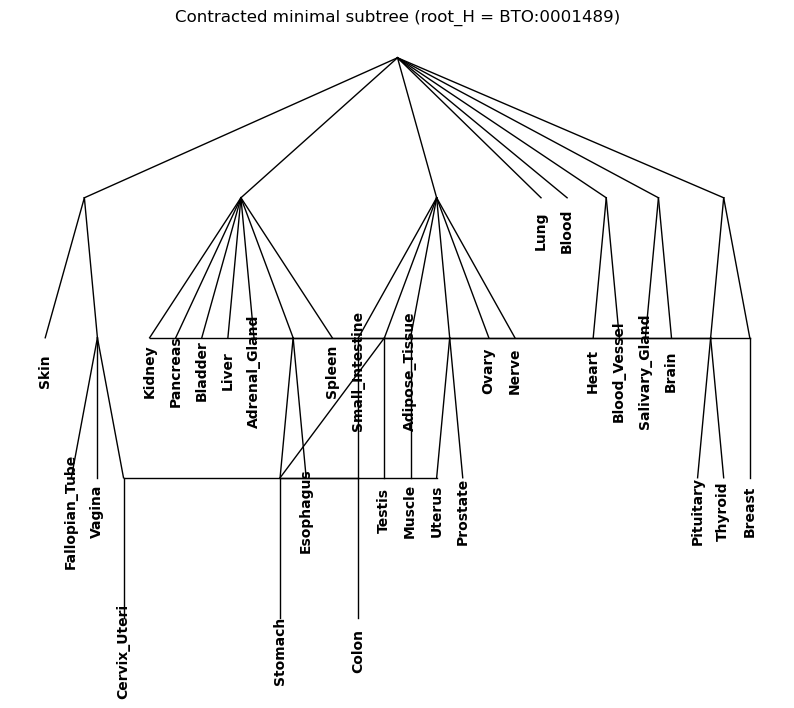

[['BTO:0004238', 'BTO:0000421', 'BTO:0000651', 'BTO:0000648', 'BTO:0000511'], ['BTO:0001489', 'BTO:0000634', 'BTO:0000416', 'BTO:0001421', 'BTO:0001424', 'BTO:0002064', 'BTO:0000421'], ['BTO:0001491', 'BTO:0001489', 'BTO:0000421', 'BTO:0000651', 'BTO:0000648', 'BTO:0000511', 'BTO:0000058'], ['BTO:0001491', 'BTO:0000671', 'BTO:0000431', 'BTO:0000522', 'BTO:0001489'], ['BTO:0001491', 'BTO:0000047', 'BTO:0001488', 'BTO:0000522', 'BTO:0001489']]


In [21]:
original_root = "BTO:0000000"
O = gtex_terms

H, C, root_H, path_map = minimal_contracted_subtree(G_undir, original_root, O)

bto_to_gtex = {v: k for k, v in gtex_to_bto.items()}
bto_to_gtex[root_H] = "Whole boody"
print(gtex_to_bto["Cervix_Uteri"])

#print(f"Original root: {original_root}")
#print(f"New subtree root (closest in H): {root_H}")
#print("Offspring:", O)
#print("Minimal subtree nodes:", sorted(H.nodes()))
#print("Minimal subtree edges:", sorted(H.edges()))
#print("---")
#print("Contracted graph nodes:", sorted(C.nodes()))
#print("Contracted graph edges and attributes:")
#for u, v, data in C.edges(data=True):
#    print(f"  {u} - {v}, length={data['length']}, path={data['path']}")
    
plot_contracted_subtree_labels_only_O(C, root_H, O, bto_to_gtex)
cycles = nx.cycle_basis(C)
print(cycles)


In [11]:
from itertools import combinations
terms = gtex_terms
n = len(terms)
dist_mat = np.zeros((n, n), dtype=float)

maxlen = 0
for i, a in enumerate(terms):
    for j, b in enumerate(terms):
        if i == j:
            dist_mat[i,j] = 0.0
        else:
            try:
                l = nx.shortest_path_length(G_undir, source=a, target=b)
                dist_mat[i,j] = l
                if l > maxlen: maxlen = l
            except nx.NetworkXNoPath:
                dist_mat[i,j] = np.nan  # no path
# optional: normalize distances to 0..1
dist_norm = dist_mat / maxlen
df_edge = pd.DataFrame(dist_norm, index=terms, columns=terms)
bto_to_gtex = {v: k for k, v in gtex_to_bto.items()}
# Rename rows and columns of df_edge
df_edge_gtex = df_edge.rename(index=bto_to_gtex, columns=bto_to_gtex)
df_edge_gtex.to_csv("tissue_distances_bto.csv", index=True)